In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

In [2]:
earthquakeDate = pd.to_datetime('2010-02-27 06:34:11 ')

In [3]:
params = {
    'filepath_or_buffer': 'dart_32412',
    'skiprows': 2,
    'delim_whitespace': True,
    'names' : 'year month day hour minute second T height'.split(),
    'na_values': 9999
}

df = pd.read_csv(**params)
df['date'] = pd.to_datetime(df['year month day hour minute second'.split()])
# df['date'] = df['date']-earthquakeDate
df = df['date height'.split()]
df.head(10)

,date,height
0,2010-03-14 23:45:00,4325.682
1,2010-03-14 23:30:00,4325.700
2,2010-03-14 23:15:00,4325.709
3,2010-03-14 23:00:00,4325.723
4,2010-03-14 22:45:00,4325.725
5,2010-03-14 22:30:00,4325.731
6,2010-03-14 22:15:00,4325.734
7,2010-03-14 22:00:00,4325.734
8,2010-03-14 21:45:00,4325.730
9,2010-03-14 21:30:00,4325.724


convert into time series

In [4]:
df = df.set_index('date')
df = df.interpolate()

In [5]:
df.head(10)

,height
date,
2010-03-14 23:45:00,4325.682
2010-03-14 23:30:00,4325.700
2010-03-14 23:15:00,4325.709
2010-03-14 23:00:00,4325.723
2010-03-14 22:45:00,4325.725
2010-03-14 22:30:00,4325.731
2010-03-14 22:15:00,4325.734
2010-03-14 22:00:00,4325.734
2010-03-14 21:45:00,4325.730


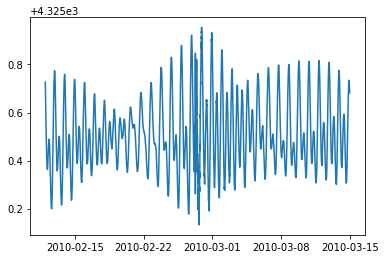

In [6]:
plt.plot(df['height'])

(733830.0, 733831.0)

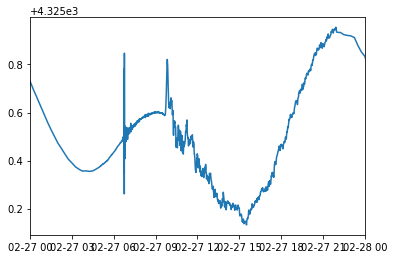

In [7]:
plt.plot(df['height'])
plt.xlim(pd.to_datetime('2010-02-27'), pd.to_datetime('2010-02-28'))

# Fourier filtering reconstruction

In [8]:
print(df.index.min(),df.index.max())
df.head()

2010-02-12 00:00:00 2010-03-14 23:45:00


,height
date,
2010-03-14 23:45:00,4325.682
2010-03-14 23:30:00,4325.700
2010-03-14 23:15:00,4325.709
2010-03-14 23:00:00,4325.723
2010-03-14 22:45:00,4325.725


The data is flipped upside down, the earliest event happens at the end.

Need also to interpolate into an uniformly spaced time array.

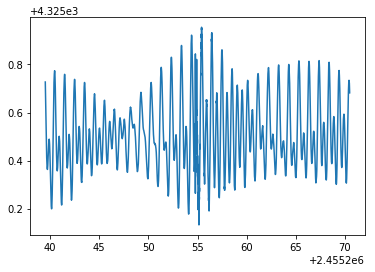

In [9]:
n = df['height'].shape[0]
t0 = df.index.to_julian_date()
dt = np.unique(np.diff(t0[::-1]))[1:].min()
t = np.arange(t0.min(),t0.max()+dt,dt)
h = np.interp(t,t0[::-1],df['height'][::-1])
h = h
plt.plot(t,h)

Filter according to a "cut" frequency and reconstruct the corresponding high/low freq signals

In [10]:
d = (df.index.max()-df.index.min())

In [11]:
t0 = pd.to_datetime('2010-02-26 17:00:00').to_julian_date()
tf = pd.to_datetime('2010-02-27 17:00:00').to_julian_date()
tearthquake = earthquakeDate.to_julian_date()

In [12]:
for i in range(15):
    base = 60*60/d.total_seconds()
    factor = (0.2+i/128)
    cut = factor*base #frequency cut, 1/base = 0.5 hours
    
    a = np.fft.fft(h)
    freq = np.fft.fftfreq(h.shape[0])
    alow = np.where(np.abs(freq)<cut,0.0,a)
    ahigh = np.where(np.abs(freq)>=cut,0.0,a)

    hlow = np.fft.ifft(alow)
    hhigh = np.fft.ifft(ahigh)

    print('2° peak = {}, factor = {}'.format(hlow.real[np.argsort(hlow.real)[-2]],factor))

2° peak = 0.4712494393486831, factor = 0.2
2° peak = 0.4695773634751949, factor = 0.2078125
2° peak = 0.4696895152674242, factor = 0.215625
2° peak = 0.4699250785555175, factor = 0.2234375
2° peak = 0.46967284086011407, factor = 0.23125
2° peak = 0.46977477433381765, factor = 0.2390625
2° peak = 0.40375908188039544, factor = 0.246875
2° peak = 0.2911436143786229, factor = 0.2546875
2° peak = 0.23282552964211267, factor = 0.2625
2° peak = 0.22999039937340524, factor = 0.2703125
2° peak = 0.2306486819785276, factor = 0.278125
2° peak = 0.2307807219595332, factor = 0.2859375
2° peak = 0.23065036316678683, factor = 0.29375
2° peak = 0.2304458798948029, factor = 0.3015625
2° peak = 0.23039639100218887, factor = 0.309375


# 

El 2° peak se estabiliza en 0.23 aprox

## Resulting time series in time window of interest

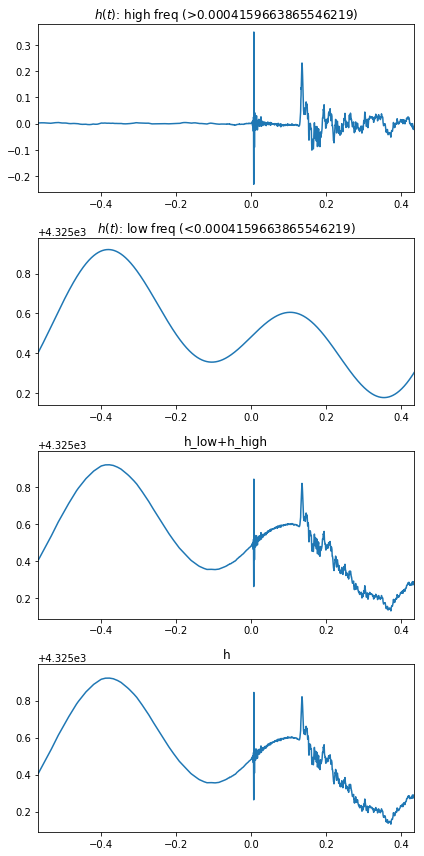

In [26]:
plt.figure(figsize=(6,12))
plt.subplot(411)
plt.plot(t-tearthquake,hlow.real)
plt.title(r'$h(t)$: high freq (>{})'.format(cut))
plt.xlim(t0-tearthquake,tf-tearthquake)

plt.subplot(412)
plt.plot(t-tearthquake,hhigh.real)
plt.title(r'$h(t)$: low freq (<{})'.format(cut))
plt.xlim(t0-tearthquake,tf-tearthquake)

plt.subplot(413)
plt.plot(t-tearthquake,hlow.real+hhigh.real)
plt.title('h_low+h_high')
plt.xlim(t0-tearthquake,tf-tearthquake)

plt.subplot(414)
plt.plot(t-tearthquake,h)
plt.xlim(t0-tearthquake,tf-tearthquake)
plt.title('h')
plt.tight_layout()

## Resulting time series in complete range time window

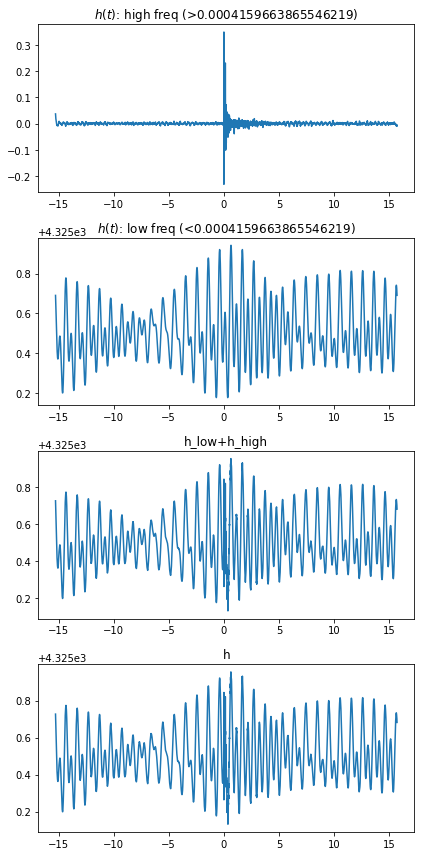

In [14]:
plt.figure(figsize=(6,12))
plt.subplot(411)
plt.plot(t-tearthquake,hlow.real)
plt.title(r'$h(t)$: high freq (>{})'.format(cut))

plt.subplot(412)
plt.plot(t-tearthquake,hhigh.real)
plt.title(r'$h(t)$: low freq (<{})'.format(cut))

plt.subplot(413)
plt.plot(t-tearthquake,hlow.real+hhigh.real)
plt.title('h_low+h_high')

plt.subplot(414)
plt.plot(t-tearthquake,h)
plt.title('h')
plt.tight_layout()

# Harmonics

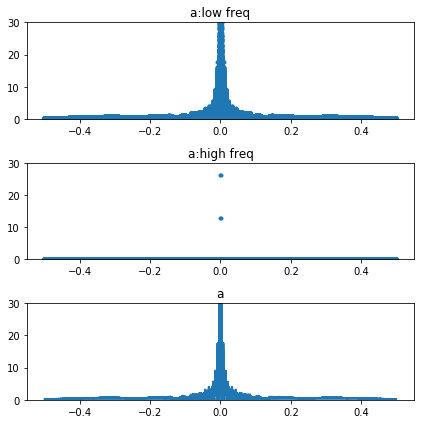

In [27]:
plt.subplot(311)
plt.plot(freq,np.abs(alow),'.')
plt.ylim(0,30)
plt.title('a:low freq')

plt.subplot(312)
plt.plot(freq,np.abs(ahigh),'.')
plt.ylim(0,30)
plt.title('a:high freq')

plt.subplot(313)
plt.title('a')
plt.plot(freq,np.abs(a))
plt.ylim(0,30)

plt.gcf().set_size_inches((6,6))
plt.tight_layout()


# Compare with previous one

In [28]:
d = np.loadtxt('../comparison/32412_notide_2010.txt')

(0.08333333333333333, 0.25)

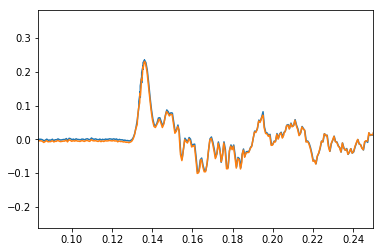

In [43]:
plt.plot(d[:,0]/60/60/24,d[:,1])
plt.plot(t-tearthquake,hlow.real)
plt.xlim(2/24,6/24)